# Setup

In [1]:
import sys
sys.path.append('/mnt/c/Users/Arnisa/Desktop/MP/mp-tl-study')
from functions.visualization_utils import *

## Load Data

In [2]:
# load baselines: filename!!
with open('results/baselines_regular_classes.json', 'r') as f:
    baselines = json.load(f)
baselines = baselines[1:]
baselines = [result for result in baselines if result["sampled_percentage"] in [0.001, 0.01, 0.1, 0.5, 1.0]]

# load results; filename
with open('results/cuts_regular_classes_FR.json', 'r') as f:
    results = json.load(f)
params = results[0]
results = results[1:]
results = [result for result in results if result["sampled_percentage"] in [0.001, 0.01, 0.1, 0.5, 1.0]]

df_empirical = pd.DataFrame(baselines + results)
df_empirical.rename(columns={
    'lr': 'learning rate',
    'sampled_percentage': 'Percentage',
    'sampled_cut_point': 'Cut Point',
    'repeat': 'Trial',
    'train_acc': 'Train Accuracy',
    'test_acc': 'Test Accuracy'
}, inplace=True)

df_empirical.tail()

,learning rate,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy
635,0.001,1.0,6,0,0.620983,0.580833
636,0.001,1.0,6,1,0.617383,0.579667
637,0.001,1.0,6,2,0.616678,0.577500
638,0.001,1.0,6,3,0.619387,0.579333
639,0.001,1.0,6,4,0.621242,0.578667


In [3]:
# OPTIONAL: load another experiment to compare (not the baselines because they are already loaded)
with open('results/cuts_regular_classes_FT.json', 'r') as f:
    results = json.load(f)
params = results[0]
results = results[1:]
results = [result for result in results if result["sampled_percentage"] in [0.001, 0.01, 0.1, 0.5, 1.0]]

df_other = pd.DataFrame(baselines + results)
df_other.rename(columns={
    'lr': 'learning rate',
    'sampled_percentage': 'Percentage',
    'sampled_cut_point': 'Cut Point',
    'repeat': 'Trial',
    'train_acc': 'Train Accuracy',
    'test_acc': 'Test Accuracy'
}, inplace=True)

df_other.tail()

,learning rate,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy
635,0.001,1.0,6,0,0.620983,0.617400
636,0.001,1.0,6,1,0.617383,0.613333
637,0.001,1.0,6,2,0.616678,0.613567
638,0.001,1.0,6,3,0.619387,0.615533
639,0.001,1.0,6,4,0.621242,0.617367


# 1. The plots
First the one on the left, and the one on the right (with the hatches)

/home/arnisa/anaconda3/envs/tutorial6_env/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Freeze = True, Reinitialize = True, Pooling = True, Learning rate = 0.001


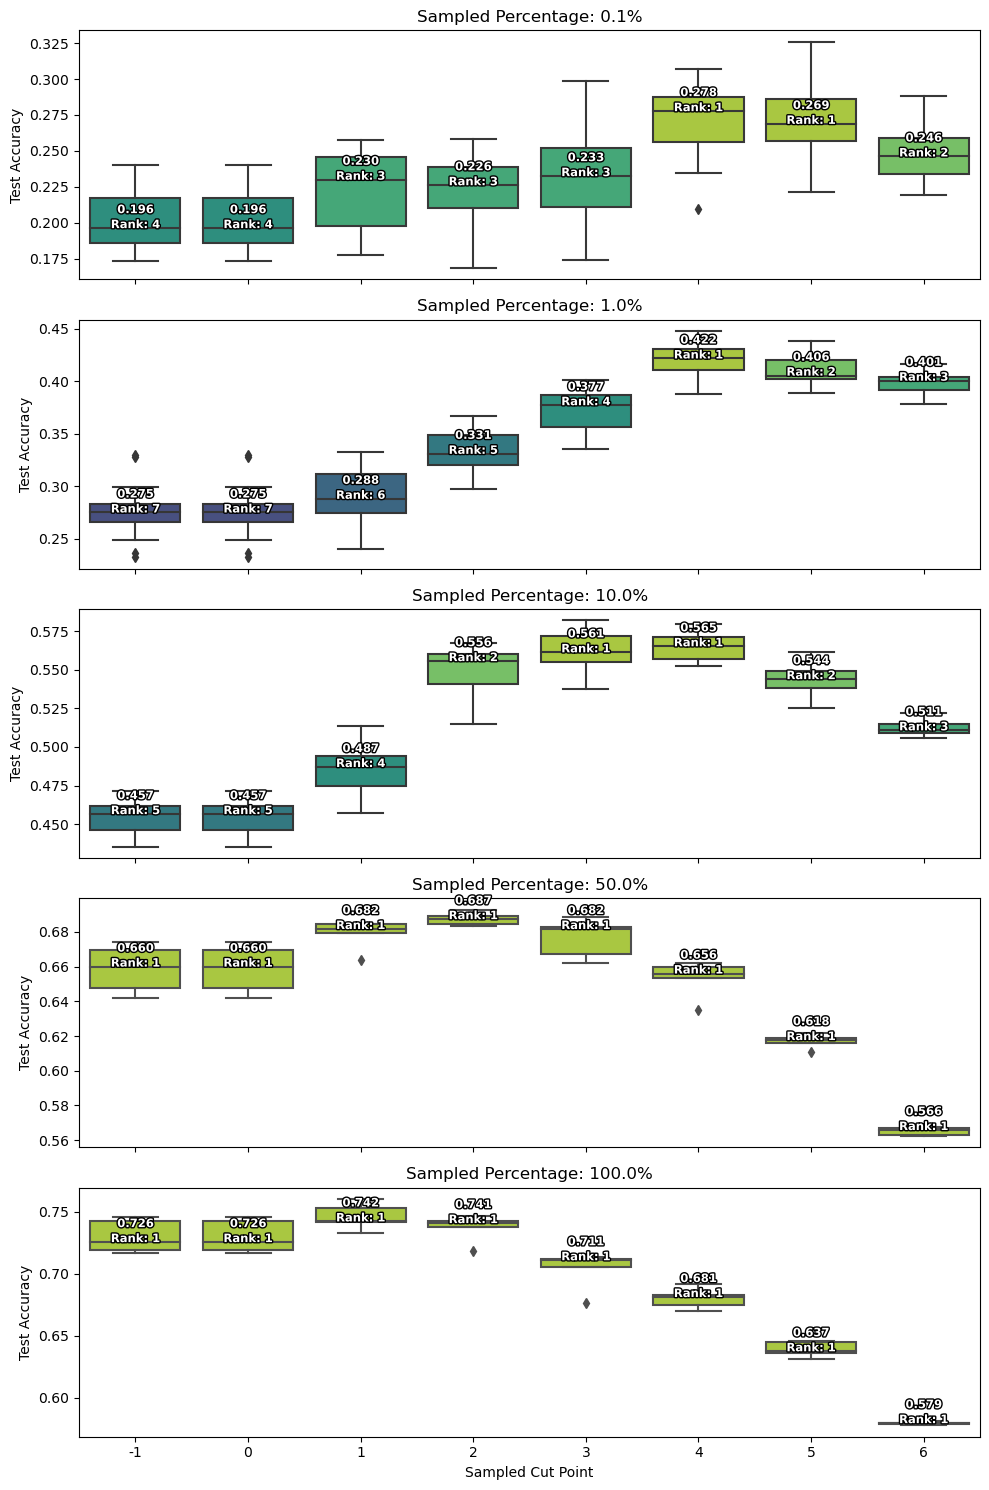

In [4]:
# run statistical tests below to get the df_rankings
_, df_rankings = get_rankings(df=df_empirical)
ranks_sorted = box_plot(df=df_empirical, rank_df=df_rankings, params=params, add_baseline=False)

/home/arnisa/anaconda3/envs/tutorial6_env/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Freeze = True, Reinitialize = True, Pooling = True, Learning rate = 0.001


<module 'matplotlib.pyplot' from '/home/arnisa/anaconda3/envs/tutorial6_env/lib/python3.7/site-packages/matplotlib/pyplot.py'>

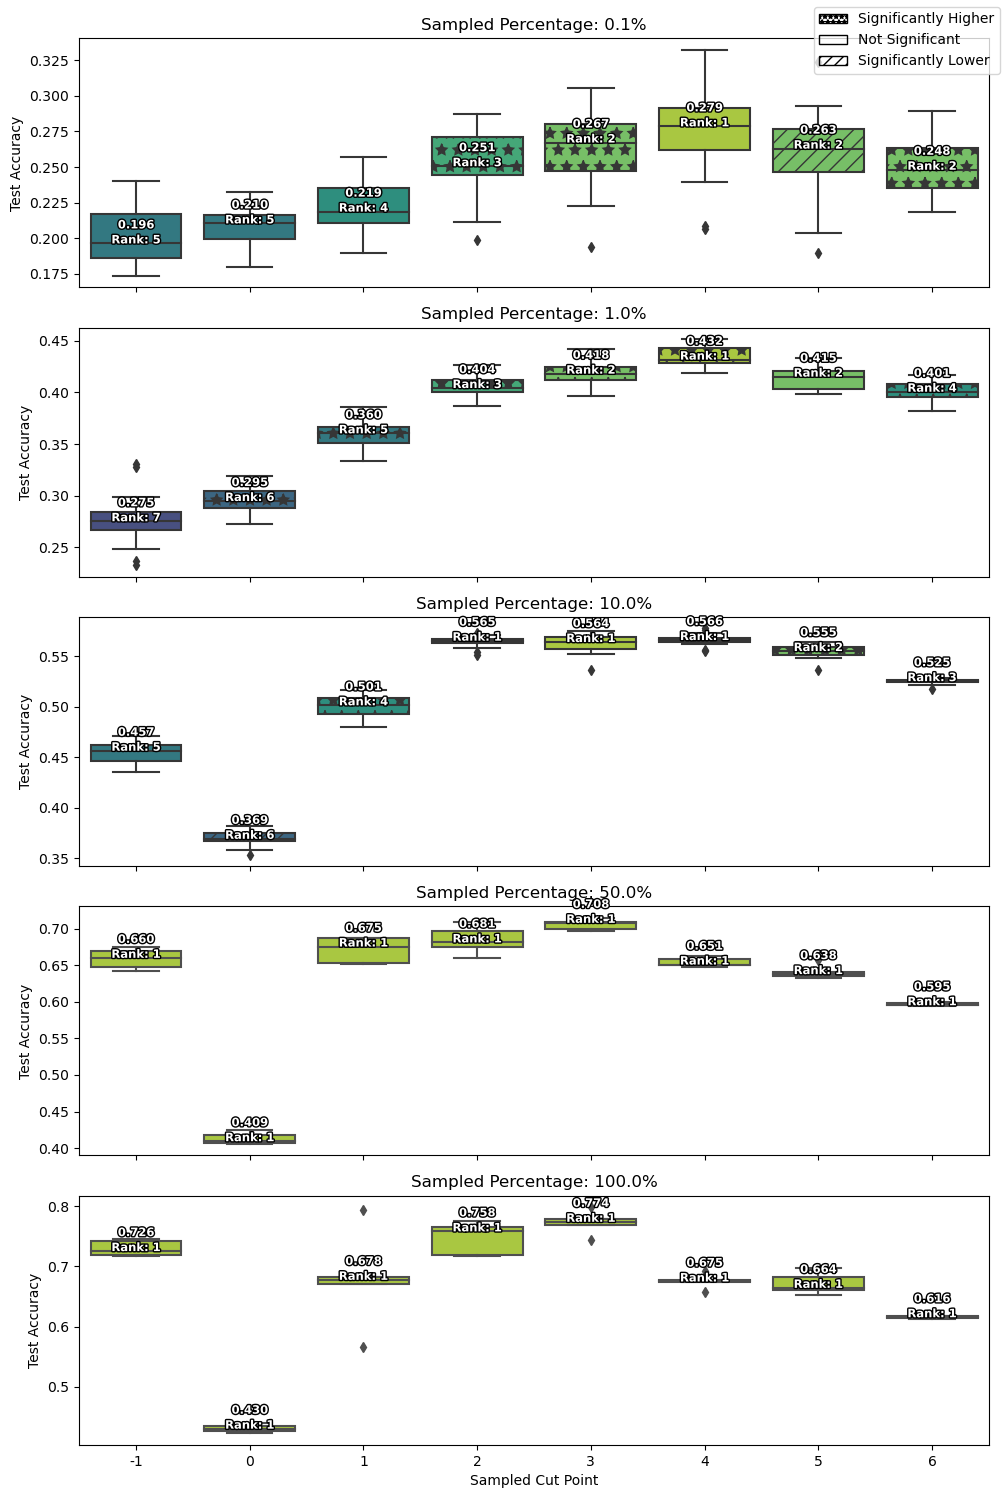

In [5]:
# run statistical tests below to get the df_rankings
_, df_rankings = get_rankings(df=df_other)
df_wilcoxon_pairwise = pairwise_comparison_multiple_plots(df_empirical, df_other)
stats_empirical = df_empirical.groupby(['Percentage', 'Cut Point']).agg({
    'Test Accuracy': 'mean',  # Add more columns/statistics as needed
})
stats_empirical = stats_empirical.reset_index()
stats_empirical.rename(columns={'Test Accuracy': 'Mean Test Accuracy'}, inplace=True)

stats_other = df_other.groupby(['Percentage', 'Cut Point']).agg({
    'Test Accuracy': 'mean',  # Add more columns/statistics as needed
})
stats_other = stats_other.reset_index()
stats_other.rename(columns={'Test Accuracy': 'Mean Test Accuracy'}, inplace=True)
# create df_rankings_empirical and df_rankings_truncated, where if one is significantly different from each other we compare the mean_test_acc of both, and the one which is bigger is ranked 1, the lower is rank 3, and if they are not significantly different they ar eboth rank 2

df_rankings_empirical = stats_empirical.copy()
df_rankings_other = stats_other.copy()

# in a for loop, compare the is_significant of two dataframes
for i in range(len(df_wilcoxon_pairwise)):
    if df_wilcoxon_pairwise.iloc[i]['is_significant']:
        if stats_empirical.iloc[i]['Mean Test Accuracy'] > df_rankings_other.iloc[i]['Mean Test Accuracy']:
            df_rankings_empirical.loc[i, 'Mean Test Accuracy'] = 8
            df_rankings_other.loc[i, 'Mean Test Accuracy'] = 1
        else:
            df_rankings_empirical.loc[i, 'Mean Test Accuracy'] = 1
            df_rankings_other.loc[i, 'Mean Test Accuracy'] = 8
    else:
        df_rankings_empirical.loc[i, 'Mean Test Accuracy'] = 5
        df_rankings_other.loc[i, 'Mean Test Accuracy'] = 5

df_rankings_empirical['rank'] = df_rankings_empirical['Mean Test Accuracy'].astype(int)
df_rankings_other['rank'] = df_rankings_other['Mean Test Accuracy'].astype(int)
box_plot(df=df_other, rank_df=df_rankings, params=params, pairwise_rank_df=df_rankings_other, pairwise=True)

# 2. Statistical Tests

### Pairwise Comparison between two experiments
Change the part "truncate=False" and "truncate=True"

In [6]:
# create df_rankings_empirical and df_rankings_truncated, where if one is significantly different from each other we compare the mean_test_acc of both, and the one which is bigger is ranked 1, the lower is rank 3, and if they are not significantly different they ar eboth rank 2
df_wilcoxon_pairwise = pairwise_comparison_multiple_plots(df_empirical, df_other)
stats_empirical = calculate_statistics(df_empirical)
stats_other = calculate_statistics(df_other)

df_rankings_empirical = stats_empirical.copy()
df_rankings_other = stats_other.copy()

# in a for loop, compare the is_significant of two dataframes
for i in range(len(df_wilcoxon_pairwise)):
    if df_wilcoxon_pairwise.iloc[i]['is_significant']:
        if stats_empirical.iloc[i]['Mean Test Accuracy'] > stats_other.iloc[i]['Mean Test Accuracy']:
            df_wilcoxon_pairwise.loc[i, "Higher"] = "truncate=False"
        else:
            df_wilcoxon_pairwise.loc[i, "Higher"] = "truncate=True"
        # print(df_wilcoxon_pairwise)
    else:
        df_wilcoxon_pairwise.loc[i, "Higher"] = "None"

# every row: is the percentage and cut significantly different between the two box plots
df_wilcoxon_pairwise["statistic"] = df_wilcoxon_pairwise["statistic"].astype(int)

latex_table = df_wilcoxon_pairwise.to_latex(index=False, float_format="%.6f")
rows = latex_table.split("\n")[4:-3]
header = latex_table.split("\n")[:4]
footer = latex_table.split("\n")[-3:]

# iterate over the rows and the df_wilcoxon_pairwise
for i, row in enumerate(rows):
    row = row.split(" & ")
    row = " & ".join([str(float(row[0].lstrip())*100)[:5]] + row[1:4] + row[-1:])
    if df_wilcoxon_pairwise.iloc[i]["is_significant"]:
        # split row with respect to " & ", take the 5th value, encapsulate it in \textbf{} and join them back
        row = "\\rowcolor{green!20}\n" + row
    rows[i] = row

# join the header, rows and footer, putting a "\\" at the end of each row
latex_table = "\n".join(rows)

In [7]:
print(latex_table)

0.1 &         -1 &          0 & 1.000000 &          None \\
0.1 &          0 &        104 & 0.119934 &          None \\
0.1 &          1 &        157 & 0.894860 &          None \\
\rowcolor{green!20}
0.1 &          2 &         25 & 0.000054 & truncate=True \\
\rowcolor{green!20}
0.1 &          3 &         18 & 0.000015 & truncate=True \\
0.1 &          4 &        152 & 0.791476 &          None \\
\rowcolor{green!20}
0.1 &          5 &         46 & 0.001027 & truncate=True \\
\rowcolor{green!20}
0.1 &          6 &         72 & 0.013555 & truncate=True \\
1.0 &         -1 &          0 & 1.000000 &          None \\
\rowcolor{green!20}
1.0 &          0 &         44 & 0.000808 & truncate=True \\
\rowcolor{green!20}
1.0 &          1 &          0 & 0.000000 & truncate=True \\
\rowcolor{green!20}
1.0 &          2 &          0 & 0.000000 & truncate=True \\
\rowcolor{green!20}
1.0 &          3 &          0 & 0.000000 & truncate=True \\
\rowcolor{green!20}
1.0 &          4 &         34 & 0.000217

### Tables for Ranking Cuts

In [8]:
df_wilcoxon_pairwise, _ = get_rankings(df=df_empirical)

df_wilcoxon_pairwise["statistic"] = df_wilcoxon_pairwise["statistic"].astype(int)

latex_table = df_wilcoxon_pairwise.to_latex(index=False, float_format="%.6f")

rows = latex_table.split("\n")[4:-3]
header = latex_table.split("\n")[:4]
footer = latex_table.split("\n")[-3:]

# iterate over the rows and the df_wilcoxon_pairwise
for i, row in enumerate(rows):
    # print(row)
    row = row.split(" & ")   
    # print(float(row[0].lstrip())*100)
    row = " & ".join([str(float(row[0].lstrip())*100)[:5]] + row[1:-1])
    if df_wilcoxon_pairwise.iloc[i]["is_significant"]:
        row = "\\rowcolor{green!20}\n" + row
    
    rows[i] = row + " \\\\"

# join the header, rows and footer, putting a "\\" at the end of each row
latex_table = "\n".join(rows)

/home/arnisa/anaconda3/envs/tutorial6_env/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [9]:
print(latex_table)

0.1 &           -1 &            0 &          0 & 1.000000 \\
\rowcolor{green!20}
0.1 &           -1 &            1 &         59 & 0.004175 \\
\rowcolor{green!20}
0.1 &           -1 &            2 &         48 & 0.001296 \\
\rowcolor{green!20}
0.1 &           -1 &            3 &         39 & 0.000430 \\
\rowcolor{green!20}
0.1 &           -1 &            4 &          1 & 0.000000 \\
\rowcolor{green!20}
0.1 &           -1 &            5 &          0 & 0.000000 \\
\rowcolor{green!20}
0.1 &           -1 &            6 &          5 & 0.000001 \\
\rowcolor{green!20}
0.1 &            0 &            1 &         59 & 0.004175 \\
\rowcolor{green!20}
0.1 &            0 &            2 &         48 & 0.001296 \\
\rowcolor{green!20}
0.1 &            0 &            3 &         39 & 0.000430 \\
\rowcolor{green!20}
0.1 &            0 &            4 &          1 & 0.000000 \\
\rowcolor{green!20}
0.1 &            0 &            5 &          0 & 0.000000 \\
\rowcolor{green!20}
0.1 &            0 &        